In [247]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from skimage import io
from tqdm import tqdm
import os
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.utils import np_utils
from keras.optimizers import Adam
from keras import layers
from keras import models
%matplotlib inline

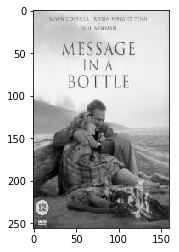

In [248]:
%matplotlib inline
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

img = load_img('./images/1_resize_gray.jpeg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
plt.imshow(img)


# Read Data

In [249]:
path = './'

In [250]:
dataTraining = pd.read_csv(os.path.join(path, 'dataTraining.csv'), encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv(os.path.join(path, 'dataTesting.csv'), encoding='UTF-8', index_col=0)

In [251]:
dataTraining.head()

,year,title,plot,genres,rating
id,,,,,
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [252]:
dataTesting.head()

,year,title,plot
id,,,
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


# Read Images

In [253]:
image = io.imread(os.path.join(path, 'images', str(dataTraining.index[0]) + '_resize_gray.jpeg'))

In [254]:
image

array([[ 3,  3,  3, ..., 57, 55, 51],
       [ 3,  3,  3, ..., 99, 98, 95],
       [ 3,  3,  3, ..., 97, 96, 94],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

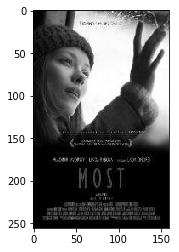

In [255]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(image, cmap='gray')

Read all images

In [10]:
images_training = []
for i in tqdm(dataTraining.index):
    images_training.append(io.imread(os.path.join(path, 'images', str(i) + '_resize_gray.jpeg')))

100%|█████████████████████████████████████████████████████████████████████████████| 7895/7895 [01:04<00:00, 122.21it/s]


In [11]:
images_training = np.stack(images_training)

images_training.shape, dataTraining.shape[0]

((7895, 256, 160), 7895)

In [12]:
images_testing = []
for i in tqdm(dataTesting.index):
    images_testing.append(io.imread(os.path.join(path, 'images', str(i) + '_resize_gray.jpeg')))

images_testing = np.stack(images_testing)

images_testing.shape, dataTesting.shape[0]

100%|█████████████████████████████████████████████████████████████████████████████| 3383/3383 [00:28<00:00, 119.36it/s]


((3383, 256, 160), 3383)

# Create y

In [13]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [176]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(images_training, y_genres, test_size=0.1, random_state=42)

In [177]:
y_genres

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

In [178]:
# dimensions of our images.
img_width, img_height = 256, 160



# Definiendo nuestro modelo y las capas usadas.

### Para la creación de nuestro modelo se usaron diferentes capas de Conv1D, con diferetes funciones de activación como ReLu y SoftMax, ademas el Kernerl size varia para cada capa.

### Aunque al final usamos sigmoides, en las demas capas ocultas de la red neuronal usamos Rectified Linear Units. Una función de activación ReLU tiene una salidad de 0 si la entrada es menor que 0, o la mantiene igual (Entrada igual a la salida) Las activaciones RELU son las funciones de activación no lineal mas simples que hay, dado si la entrada es positiva la derivada es 1. es decir no hay propagacion de errores, y su entrenamiento es muy rapido en redes largas.

### La funcion softmax divide las salidas de cada unidad en 1s y 0s. Pero también divide cada salida de tal modo que la suma total de las salidas se 1. La salida de una función Softmax es equivalente a una distribucion de probabilidad categorica, te dice la probabilidad de que cada uno de los casos sea cierto. Se usapara cualquier numero de clases.

In [235]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import layers
from keras import models


  model = Sequential()
model.add(Conv1D(32,kernel_size=3, activation='softmax',
                 input_shape=(img_width, img_height)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, 4, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='softmax'))
model.add(Dropout(0.5))
model.add(Dense(24, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_71 (Conv1D)           (None, 254, 32)           15392     
_________________________________________________________________
max_pooling1d_67 (MaxPooling (None, 127, 32)           0         
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 125, 32)           3104      
_________________________________________________________________
max_pooling1d_68 (MaxPooling (None, 62, 32)            0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 59, 64)            8256      
_________________________________________________________________
max_pooling1d_69 (MaxPooling (None, 29, 64)            0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 1856)              0         
__________

# Compilación

Compilamos nuestro modelo usando una función de loss Categorical_croosentrop y un optimisador RMSprop.



In [236]:

model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

# Entrenamiento del modelo

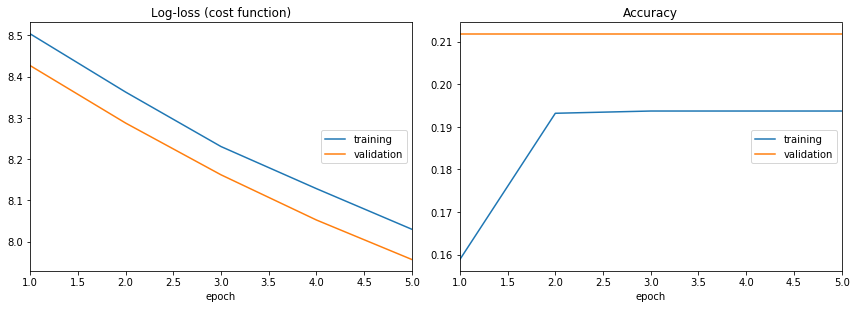

In [237]:
from livelossplot import PlotLossesKeras
model.fit(X_train, y_train_genres, batch_size=64, epochs=5, verbose=3,validation_split=0.2,callbacks=[PlotLossesKeras()])

In [238]:
y_pred=model.predict(X_test)
y_pred.shape

(790, 24)

# Predicciones en la muestra de test


In [239]:
y_pred

array([[0.5752148 , 0.49266183, 0.3257905 , ..., 0.68983483, 0.3039866 ,
        0.29154402],
       [0.5752148 , 0.49266183, 0.3257905 , ..., 0.68983483, 0.3039866 ,
        0.29154402],
       [0.5752148 , 0.49266183, 0.3257905 , ..., 0.68983483, 0.3039866 ,
        0.29154402],
       ...,
       [0.5752148 , 0.49266183, 0.3257905 , ..., 0.68983483, 0.3039866 ,
        0.29154402],
       [0.5752148 , 0.49266183, 0.3257905 , ..., 0.68983483, 0.3039866 ,
        0.29154402],
       [0.5752148 , 0.49266183, 0.3257905 , ..., 0.68983483, 0.3039866 ,
        0.29154402]], dtype=float32)

In [240]:
score2 = model.evaluate(X_test, y_test_genres)
print('Test score:', score2[0])
print('Test accuracy:', score2[1])
score2

790/790 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 2ms/step
Test score: 8.10030015148694
Test accuracy: 0.20126582293570797


[8.10030015148694, 0.20126582293570797]

# Predecciones para la competencia

In [241]:
y_pred2=model.predict(images_testing)
y_pred2

array([[0.5752148 , 0.49266183, 0.3257905 , ..., 0.68983483, 0.3039866 ,
        0.29154402],
       [0.5752148 , 0.49266183, 0.3257905 , ..., 0.68983483, 0.3039866 ,
        0.29154402],
       [0.5752148 , 0.49266183, 0.3257905 , ..., 0.68983483, 0.3039866 ,
        0.29154402],
       ...,
       [0.5752148 , 0.49266183, 0.3257905 , ..., 0.68983483, 0.3039866 ,
        0.29154402],
       [0.5752148 , 0.49266183, 0.3257905 , ..., 0.68983483, 0.3039866 ,
        0.29154402],
       [0.5752148 , 0.49266183, 0.3257905 , ..., 0.68983483, 0.3039866 ,
        0.29154402]], dtype=float32)

In [ ]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

#y_pred_test_genres = clf.predict_proba(images_testing_pca)

pd.DataFrame(y_pred2, index=dataTesting.index, columns=cols).to_csv('pred_genres_imgNN.csv', index_label='ID')

# Train multi-class multi-label model

### Se utilizaron varias clasificadores a traves de sckilearn. K vecinos, Gaussian Naive Bayes, RandomForest y Extra trees classifier

In [243]:
images_training = []
for i in tqdm(dataTraining.index):
    images_training.append(io.imread(os.path.join(path, 'images', str(i) + '_resize_gray.jpeg')).flatten())

100%|██████████████████████████████████████████████████████████████████████████████| 7895/7895 [01:41<00:00, 77.91it/s]


In [245]:
images_training = np.stack(images_training)
images_testing = []
for i in tqdm(dataTesting.index):
    images_testing.append(io.imread(os.path.join(path, 'images', str(i) + '_resize_gray.jpeg')).flatten())

images_testing = np.stack(images_testing)

images_testing.shape, dataTesting.shape[0]
images_training.shape, dataTraining.shape[0]

100%|██████████████████████████████████████████████████████████████████████████████| 3383/3383 [00:46<00:00, 72.11it/s]


((7895, 40960), 7895)

In [256]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [257]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(images_training, y_genres, test_size=0.1, random_state=42)

In [258]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [261]:
clf = OneVsRestClassifier(KNeighborsClassifier())


In [ ]:
clf.fit(X_train, y_train_genres)


In [ ]:
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')


In [ ]:
clf2 = OneVsRestClassifier(GaussianNB())
clf2.fit(X_train, y_train_genres)
y_pred_genres2 = clf2.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')



In [ ]:
clf3 = OneVsRestClassifier(ExtraTreesClassifier())
clf3.fit(X_train, y_train_genres)

y_pred_genres3 = clf3.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

# Apply models to test

In [231]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

#y_pred_test_genres = clf.predict_proba(images_testing_pca)

pd.DataFrame(y_pred2, index=dataTesting.index, columns=cols).to_csv('pred_genres_img.csv', index_label='ID')